In [1]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import gin
import ddsp
from ddsp import spectral_ops, core
from IPython.display import Audio
import ipywidgets as widgets

import warnings
warnings.filterwarnings("ignore")

from utils import specplot
from composition.common import (
    oscillate, perc, adsr, silence, rescale, autotune
)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
sample_rate = 16000
hop_size = 64
step_dur = hop_size / sample_rate

In [5]:
model = pretrained.value

# Pretrained models.
PRETRAINED_DIR = f'pretrained/{model.lower()}'

model_dir = PRETRAINED_DIR
gin_file = os.path.join(model_dir, 'operative_config-0.gin')

# Parse gin config,
with gin.unlock_config():
    gin.parse_config_file(gin_file, skip_unknown=True)

# Assumes only one checkpoint in the folder, 'ckpt-[iter]`.
ckpt_files = [f for f in os.listdir(model_dir) if 'ckpt' in f]
ckpt_name = ckpt_files[0].split('.')[0]
ckpt = os.path.join(model_dir, ckpt_name)

# Ensure dimensions and sampling rates are equal
time_steps_train = gin.query_parameter('F0LoudnessPreprocessor.time_steps')
n_samples_train = gin.query_parameter('Harmonic.n_samples')
hop_size = int(n_samples_train / time_steps_train)

time_steps = len(af['f0_hz'])
n_samples = time_steps * hop_size

gin_params = [
    'Harmonic.n_samples = {}'.format(n_samples),
    'FilteredNoise.n_samples = {}'.format(n_samples),
    'F0LoudnessPreprocessor.time_steps = {}'.format(time_steps),
    'oscillator_bank.use_angular_cumsum = True',  # Avoids cumsum accumulation errors.
]

with gin.unlock_config():
    gin.parse_config(gin_params)


# Set up the model just to predict audio given new conditioning
model = ddsp.training.models.Autoencoder()
model.restore(ckpt)

# Build model by running a batch through it.
_ = model(af, training=False)

In [3]:
pretrained = widgets.Dropdown(
    options=['Violin', 'Flute', 'Flute2', 'Cello', 'Viola'],
    value='Cello',
    description='Pretrained:',
    disabled=False,
)
display(pretrained)

Dropdown(description='Pretrained:', index=3, options=('Violin', 'Flute', 'Flute2', 'Cello', 'Viola'), value='C…

27.0


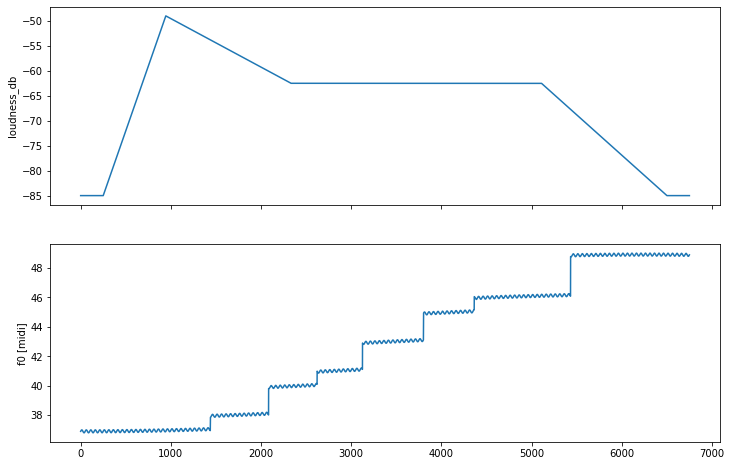

In [7]:
loudness = adsr(0.25, 0.5, 1., 0.5, 25., .8, 0.5)
preroll = silence(1.)
postroll = silence(1.)
loudness = np.concatenate([preroll, loudness, postroll])
loudness = rescale(loudness, -85, -40)
    

n_steps = len(loudness)
duration = n_steps * step_dur
print(duration)

t = np.linspace(0, duration, n_steps)

pitch = oscillate(t, 0.01, 36, 12, 0, 2)
pitch = autotune(pitch, 0.9, scale='harmonic_minor', rotate=0, offset=2)
pitch += oscillate(t, 5, 0, 0.1)

af = {
    'f0_hz': librosa.midi_to_hz(pitch),
    'loudness_db': loudness
}

# Plot
fig, ax = plt.subplots(nrows=2, 
                       ncols=1, 
                       sharex=True,
                       figsize=(12, 8))

ax[0].plot(af['loudness_db'])
ax[0].set_ylabel('loudness_db')

ax[1].plot(librosa.hz_to_midi(af['f0_hz']))
ax[1].set_ylabel('f0 [midi]')
pass

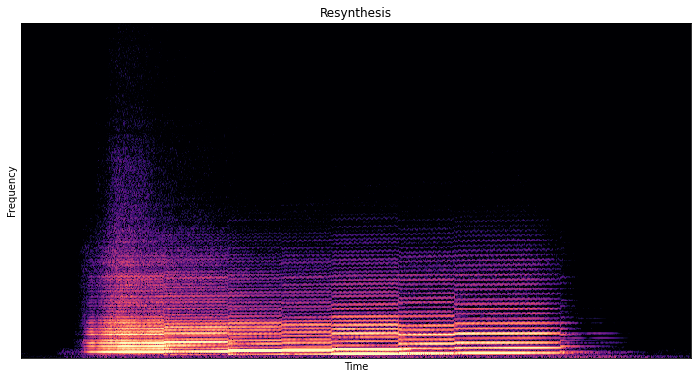

In [8]:
# Run a batch of predictions.
outputs = model(af, training=False)
audio_gen = model.get_audio_from_outputs(outputs)

play = Audio(audio_gen, rate=16000)
display(play)
specplot(audio_gen)
_ = plt.title("Resynthesis")